In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json
import scipy.stats as st
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec


%matplotlib inline
plt.rcParams.update({'font.size': 12})
# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

In [4]:
DA_dir = Path.cwd() / "models"
noDA_dir = Path.cwd().parent / "FinalPaperMVEnoDAv2" / "models"
lets = list("abcde".upper())
DA_paths = [DA_dir / ("Run" + i + "_snll") for i in lets]
noDA_paths = [noDA_dir / ("Run" + i + "_noDA_snll") for i in lets]

In [5]:
def get_models(paths):
    mods = []
    stats = []
    for mod_path in paths:
        mod_json = mod_path.parent / (mod_path.name + ".json")
        model = NeuralNetworkMVEv3(npix=40).cuda()
        model.load_state_dict(torch.load(mod_path)['state_dict'])
        stats.append(json.load(open(mod_json, 'r')))
        mods.append(model)

        
    return mods, stats

def get_test_predictions(model, test_dataloader):
    all_mean = []
    all_var = []
    all_truth = []
    
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.float()
            
            pred, _ = model(X.cuda())
            mean = list(pred[:, 0].cpu().numpy())
            var = list(pred[:, 1].cpu().numpy())
            truth = list(y.cpu().numpy())

            all_mean = all_mean + mean
            all_var = all_var + var
            all_truth = all_truth + truth

    return np.array(all_mean), np.array(all_var), np.array(all_truth)

def evaluate_nll(mean, var, truth):
    var = torch.tensor(var)
    nll = float(loss_bnll(mean, var, truth, beta = 0.0))
    return nll

def evaluate_r2(mean, truth):
    return r2_score(truth, mean)


def calculate_coverage(mean, var, truth):
    """
    Calculates the fraction of images with correct prediction within each confidence level (0% - 100%).
    This assumes the variance is based on a gaussian distribution.
    
    E.g. In 100 lenses, if 30 lenses have predictions within a 50% confidence interval, the point
    (50, 30) will be present.

    At 0%, no lenses should be in the confidence interval. 
    At 100%, all lenses should be in the confidence interval.
    """

    # Convert variance to standard deviation
    sig = np.sqrt(var)

    # Calculate zscore = (x - mu) / sig, and take absolute value, e.g. 1.96
    zscore = np.abs((mean - truth) / sig)

    # Calculate the fraction of gaussian within zscore sigma for two-tailed gaussian
    one_tail_cl = st.norm.cdf(zscore) # e.g. cdf(1.96) = 0.975 = 97.5% of gaussian
    two_tail_cl = 1 - ((1 - one_tail_cl) * 2) # total gaussian - ((excluded 2.5% of gaussian) * 2)

    # Above (two_tail_cl)% confidence, image will be excluded from correct prediction
    # Equivalently, we can sort the array against the fraction of lenses
    confidence_level = np.sort(two_tail_cl)
    image_fraction = np.arange(len(two_tail_cl)) / len(two_tail_cl)

    return confidence_level, image_fraction


def print_score(name, vals, method = np.median):
    print(name + ":", method(vals).round(4), "+-", np.std(vals).round(4))

def random_residual_sample(var, truth, n_points = 30):
    # Define 30 theta_E bins, 31 bin edges
    bins = np.linspace(1.0, 3.0, n_points + 1)

    # Sort all images into respective bins, 0-29
    indices = np.digitize(truth, bins) - 1 

    # Choose random point for every bin, k from 0-29
    # Variance should not be zero
    ord_idx = np.array([np.random.choice(np.where((indices == k) & (var > 0))[0], 1) for k in range(0, n_points)])

    # waht did i do this for again?
    rand_idx = ord_idx[:, 0]

    return rand_idx

def bin_average(x, y, n_points = 30):
    
    bins = np.linspace(1.0, 3.0, n_points + 1)
    indices = np.digitize(x, bins) - 1 
    
    avg_y = []
    for k in range(0, n_points):
        bin_y = y[np.where((indices == k) & (y > 0))[0]]
        avg_y.append(bin_y.mean())
        if len(bin_y) == 0:
            print(k)
    avg_x = bins[:-1] + (bins[1] - bins[0]) / 2
    return avg_x, avg_y
    
def get_kde(resid, lims = 0.6):
    # KDE estimation
    kde = gaussian_kde(resid, bw_method=0.5)
    x_vals = np.linspace(-lims, lims, 1000)
    kde_values = kde(x_vals)

    return x_vals, kde_values

def split_mvt(mvt, i):
    return mvt[i, 0], mvt[i, 1], mvt[i, 2]

In [6]:
DA_models, DA_stats = get_models(DA_paths)
noDA_models, noDA_stats = get_models(noDA_paths)

In [12]:
model_types = {'DA': DA_models, 'noDA': noDA_models}
dataloaders = {'source': source_test_dataloader, 'target': target_test_dataloader}

# Initialize dictionaries for predictions and metrics
mvt = {}
nll_scores = {}
r2_scores = {}
coverage_scores = {}

# Get predictions and evaluate metrics
for model_type, models in model_types.items():
    for data_type, dataloader in dataloaders.items():
        
        key = f"{model_type}_{data_type}"
        mvt[key] = {}
        nll_scores[key] = {}
        r2_scores[key] = {}
        coverage_scores[key] = {}
        
        for imod, mod in enumerate(models):
            
            mvt[key][imod] = dict.fromkeys(["mean", "var", "truth"])
            curr_mvt = mvt[key][imod]

            curr_mvt["mean"], curr_mvt["var"], curr_mvt["truth"] = get_test_predictions(mod, dataloader)
            nll_scores[key][imod] = evaluate_nll(curr_mvt["mean"], curr_mvt["var"], curr_mvt["truth"])
            r2_scores[key][imod] = evaluate_r2(curr_mvt["mean"], curr_mvt["truth"])
            coverage_scores[key][imod] = calculate_coverage(curr_mvt["mean"], curr_mvt["var"], curr_mvt["truth"])

/tmp/ipykernel_12654/859667930.py:59: RuntimeWarning: divide by zero encountered in divide
  zscore = np.abs((mean - truth) / sig)
/tmp/ipykernel_12654/859667930.py:59: RuntimeWarning: divide by zero encountered in divide
  zscore = np.abs((mean - truth) / sig)


In [13]:
for model_type, models in model_types.items():
    for data_type, dataloader in dataloaders.items():
        key = f"{model_type}_{data_type}"
        mod = mvt[key]
        mean_resid = [np.mean(np.abs(mod[i]['mean'] - mod[i]['truth'])) for i in range(len(models))]
        print_score("Mean Resid " + key, mean_resid)

Mean Resid DA_source: 0.0388 +- 0.0047
Mean Resid DA_target: 0.0462 +- 0.0049
Mean Resid noDA_source: 0.0165 +- 0.0019
Mean Resid noDA_target: 0.0583 +- 0.0227


In [8]:
for model_type, models in model_types.items():
    for data_type, dataloader in dataloaders.items():
        key = f"{model_type}_{data_type}"
        mod = mvt[key]
        mean_resid = [np.mean(np.abs(mod[i]['mean'] - mod[i]['truth'])) for i in range(len(models))]
        print_score("Mean Resid " + key, mean_resid)

Mean Resid DA_source: 0.0388 +- 0.0048
Mean Resid DA_target: 0.0461 +- 0.0049
Mean Resid noDA_source: 0.0165 +- 0.0019
Mean Resid noDA_target: 0.0586 +- 0.0228


In [9]:
for model_type, models in model_types.items():
    for data_type, dataloader in dataloaders.items():
        key = f"{model_type}_{data_type}"
        mod = mvt[key]
        mean_al = [np.mean(mod[i]['var']) for i in range(len(models))]
        print_score("Mean sig_al " + key, mean_al)

Mean sig_al DA_source: 0.0039 +- 0.0007
Mean sig_al DA_target: 0.0039 +- 0.0007
Mean sig_al noDA_source: 0.0004 +- 0.0002
Mean sig_al noDA_target: 0.0004 +- 1e-04


In [10]:
for model_type, models in model_types.items():
    for data_type, dataloader in dataloaders.items():
        key = f"{model_type}_{data_type}"
        print_score("R2 " + key, list(r2_scores[key].values()))

R2 DA_source: 0.9917 +- 0.0019
R2 DA_target: 0.9876 +- 0.0023
R2 noDA_source: 0.9986 +- 0.0003
R2 noDA_target: 0.9721 +- 0.0207


In [11]:
for model_type, models in model_types.items():
    for data_type, dataloader in dataloaders.items():
        key = f"{model_type}_{data_type}"
        print_score("NLL " + key, list(nll_scores[key].values()))

NLL DA_source: -2.4326 +- 0.1434
NLL DA_target: -2.2868 +- 0.139
NLL noDA_source: -3.3595 +- 0.1312
NLL noDA_target: 4.6499 +- 6746.5208


In [14]:
for model_type, models in model_types.items():
    for data_type, dataloader in dataloaders.items():
        key = f"{model_type}_{data_type}"
        print_score("NLL " + key, list(nll_scores[key].values()))

NLL DA_source: -2.4303 +- 0.1441
NLL DA_target: -2.2034 +- 0.3271
NLL noDA_source: -3.3588 +- 0.1296
NLL noDA_target: 4.6833 +- 6781.5627


In [15]:
nll_scores['noDA_target']

{0: 4.6833343505859375,
 1: -1.1104176044464111,
 2: 16960.720703125,
 3: 26.429786682128906,
 4: -2.6671173572540283}

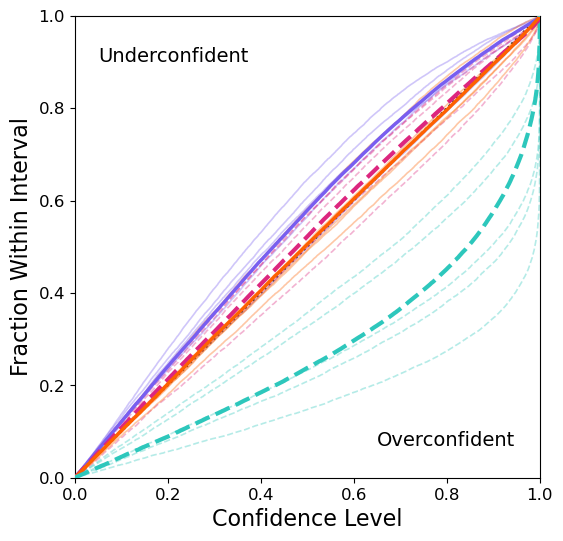

In [16]:
#plt.title("Coverage Plot", fontsize = 20)
plt.figure(figsize = (6, 6))
plt.xlabel("Confidence Level", fontsize = 16)
plt.ylabel("Fraction Within Interval", fontsize = 16)
plt.annotate("Underconfident", xy = (0.05, 0.9), fontsize = 14)
plt.annotate("Overconfident", xy = (0.65, 0.07), fontsize = 14)

#plt.fill_between([-1, 2], [-1, 2], y2 = -10, alpha = 0.02, color = 'k')
plt.plot([-1, 2], [-1, 2], color = "k", ls = ":", alpha = 0.8)


#color_opts = ['#005AB5', '#1A85FF', '#DC3220', '#D41159']
color_opts = ['#785EF0', '#DC267F', '#FE6100', '#2DC7BC']
labels = ['MVE-UDA Source', 'MVE-UDA Target', 'MVE-Only Source', 'MVE-Only Target']
lws = [2.5, 3, 2.5, 3]

ci = 0
for model_type, models in model_types.items():
    for data_type, dataloader in dataloaders.items():
        key = f"{model_type}_{data_type}"

        style = "-"
        if ci % 2 != 0:
            style = "--"
        
        for imod in range(len(models)):
            plt.plot(coverage_scores[key][imod][0], coverage_scores[key][imod][1], color = color_opts[ci], alpha = 0.35, ls = style, lw = 1.2)

        mean_cov = np.array(list(coverage_scores[key].values())).mean(axis = 0)
        plt.plot(mean_cov[0], mean_cov[1], color = color_opts[ci], lw = lws[ci], ls = style, label = labels[ci], zorder = 10)
        
        ci += 1



#plt.legend(fontsize = 10, loc = (0.05, 0.6))
plt.xlim(-0, 1)
plt.ylim(-0, 1)

plt.savefig("figures/coverage.png", bbox_inches = 'tight', dpi = 400)

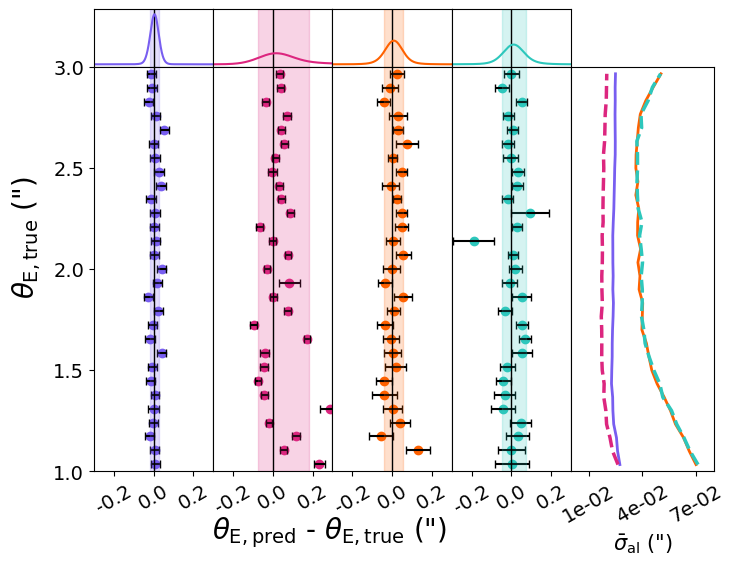

In [31]:
mod_type = ["noDA_source", "noDA_target", "DA_source", "DA_target"]
mod_no = [0, 3, 0, 0]
color_resid = ['#785EF0', '#DC267F', '#FE6100', '#2DC7BC']
labels = ['MVE-Only Source', 'MVE-Only Target', 'MVE-UDA Source', 'MVE-UDA Target', 'Sample Stdev']
style = ['-', '--', '-', '--']
lws = [2, 2.5, 2, 2.5]
lims = 0.3

# Create a figure with a GridSpec layout
fig = plt.figure(figsize=(8, 6))  
gs = gridspec.GridSpec(2, 5, height_ratios=[1, 7], width_ratios = [1, 1, 1, 1, 1.2], hspace = 0, wspace = 0) 

# Histogram plot (ax_hist) spans the entire top row
ax_hist1 = fig.add_subplot(gs[0, 0])
ax_hist2 = fig.add_subplot(gs[0, 1])
ax_hist3 = fig.add_subplot(gs[0, 2])
ax_hist4 = fig.add_subplot(gs[0, 3])

# The bottom plots (ax_resid1, ax_resid2, ax_resid3) occupy the bottom left three columns
ax_resid1 = fig.add_subplot(gs[1, 0])
ax_resid2 = fig.add_subplot(gs[1, 1])
ax_resid3 = fig.add_subplot(gs[1, 2])
ax_resid4 = fig.add_subplot(gs[1, 3])

# The additional plot on the right (ax_add) occupies the bottom right column
ax_var = fig.add_subplot(gs[1, 4])

hist_axes = [ax_hist1, ax_hist2, ax_hist3, ax_hist4]
resid_axes = [ax_resid1, ax_resid2, ax_resid3, ax_resid4, ax_var]

for ax in hist_axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim(-1, 20)
    ax.axvline(0, color = 'k', ls = '-', lw = 1)
    ax.set_xlim(-lims, lims)


for ax in resid_axes[1:]:
    ax.set_yticks([])

xt = np.linspace(-lims + 0.1, lims - 0.1, 3).round(2)

for ax in resid_axes[:-1]:
    ax.set_xlim(-lims, lims)
    ax.set_ylim(1, 3)
    ax.axvline(0, color = 'k', ls = '-', lw = 1)
    ax.set_xticks(xt)
    ax.set_xticklabels(xt, rotation = 30, fontsize = 14)

xt = [1e-2, 4e-2, 7e-2]
xtl =[f"{num:.0e}" for num in xt]
ax_var.set_xlim(0, 8e-2)
ax_var.set_xticks(xt)
ax_var.set_xticklabels(xtl, rotation = 30, fontsize = 14)
ax_var.set_ylim(1, 3)

yt = np.arange(1, 3.2, 0.5)
ytl =[f"{num:.1f}" for num in yt]
ax_resid1.set_yticks(yt)
ax_resid1.set_yticklabels(ytl, fontsize = 14)


bins = np.linspace(1.0, 3.0, 30)
mid_bins = bins + (bins[1] - bins[0])/2

# Plot the histogram
ci = 0
idx = []
all_kde = []
for t, i in zip(mod_type, mod_no):
    mod = mvt[t][i]
    resid = (mod["mean"] - mod["truth"])
    idx = random_residual_sample(mod["var"], mod["truth"])
    x_kde, y_kde = get_kde(resid, lims = lims)
    hist_axes[ci].plot(x_kde, y_kde, color = color_resid[ci])
    resid_axes[ci].errorbar(x=resid[idx], 
                      y = mid_bins, 
                      xerr=np.sqrt(mod["var"])[idx], 
                      fmt='o', 
                      alpha=1,
                      ms = 6,
                      ecolor = 'k', 
                      color = color_resid[ci], 
                      label = labels[ci],
                       barsabove = True,
                        capsize=3,
                        zorder = -2)
    mn = np.mean(resid)
    sig = np.std(resid)
    hist_axes[ci].axvspan(mn-sig, mn+sig, color = color_resid[ci], alpha = 0.2)
    resid_axes[ci].axvspan(mn-sig, mn+sig,color = color_resid[ci], alpha = 0.2)
    y_var, x_var = bin_average(mod['truth'], np.sqrt(mod['var']))
    ax_var.plot(x_var, y_var, color = color_resid[ci], ls = style[ci], lw = lws[ci], alpha = 1, )
    ci += 1

resid_axes[ci].axvspan(-11, -10,color = 'k', alpha = 0.1, label = "Sample Stdev")


fig.supxlabel(r'$\theta_\mathrm{E, pred}$ - $\theta_\mathrm{E, true}$ (")', fontsize = 20, x = 0.42, y = -0.02)
fig.supylabel(r'$\theta_\mathrm{E, true}$ (")', fontsize = 20)
ax_var.set_xlabel(r'$\bar{\sigma}_\mathrm{al}$ (")', fontsize = 15)
plt.savefig("figures/residual.png", bbox_inches = 'tight', dpi = 400)

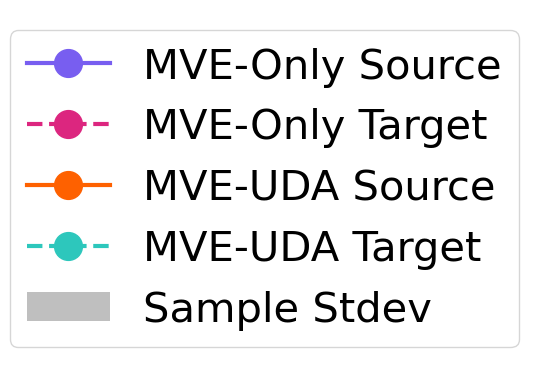

In [18]:
custom_patch = Patch(facecolor='grey', edgecolor='none', alpha=0.5)
custom_lines = [Line2D([0], [0], color=color_resid[i], lw=3, linestyle=style[i], marker = 'o', markersize = 20) for i in range(len(labels[:-1]))] + [custom_patch]
plt.legend(custom_lines, labels, fontsize = 30)
plt.axis('off')
plt.savefig('figures/resid_legend.png', bbox_inches = 'tight', dpi = 400)

In [42]:
imod = 0
trained_source_iso_da, trained_target_iso_da = generate_isomaps(source_data, target_data, DA_models[imod])
trained_source_iso_noda, trained_target_iso_noda = generate_isomaps(source_data, target_data, noDA_models[imod])

In [43]:
theta = 90

# Convert the angle to radians
theta_rad = np.deg2rad(theta)

# Rotation matrix
rotation_matrix = np.array([
    [np.cos(theta_rad), -np.sin(theta_rad)],
    [np.sin(theta_rad),  np.cos(theta_rad)]
])

tsi_noda = trained_source_iso_noda
tti_noda = trained_target_iso_noda
tsi_da = (rotation_matrix @ trained_source_iso_da.T).T
tti_da = (rotation_matrix @ trained_target_iso_da.T).T

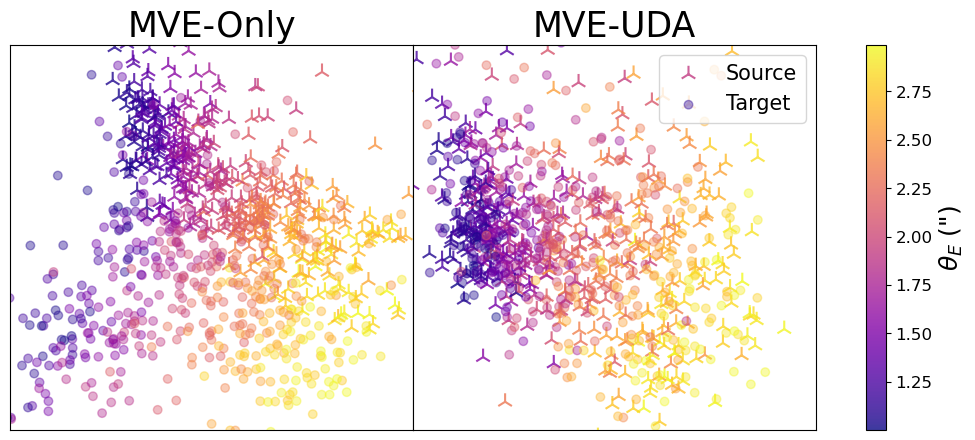

In [44]:
# Isomap
axlim1x = 30
axlim1y = 20
axlim2x = 8
axlim2y = 5
cx1 = 0
cy1 = 0
cx2 = 2.2
cy2 = -2
n = 500
cmap = 'plasma'

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
(ax1, ax2) = axes


s1a = ax1.scatter(tsi_noda[:, 0][:n], tsi_noda[:, 1][:n], s=150, marker='2', alpha = 0.8, c = isomap_source_label_sample[:n],  cmap = cmap)
s1b = ax1.scatter(tti_noda[:, 0][:n], tti_noda[:, 1][:n], s=150, marker='.', alpha = 0.4, c = isomap_target_label_sample[:n],   cmap = cmap)
s2a = ax2.scatter(tsi_da[:, 0][:n], tsi_da[:, 1][:n], s=150, marker='2', alpha = 0.8, c = isomap_source_label_sample[:n], label = "Source",cmap = cmap)
s2b = ax2.scatter(tti_da[:, 0][:n], tti_da[:, 1][:n], s=150, marker='.', alpha = 0.4, c = isomap_target_label_sample[:n], label = "Target", cmap = cmap)
ax1.set_xlim(-axlim1x + cx1, axlim1x + cx1)
ax1.set_ylim(-axlim1y + cy1, axlim1y + cy1)
ax2.set_xlim(-axlim2x + cx2, axlim2x + cx2)
ax2.set_ylim(-axlim2y + cy2, axlim2y + cy2)
ax1.set_title('MVE-Only', fontsize = 25)
ax2.set_title('MVE-UDA', fontsize = 25)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
ax2.legend(fontsize = 15, loc = 'upper right')
fig.subplots_adjust(wspace=0)
cbar = plt.colorbar(s1a, ax = axes)
cbar.set_label("$\\theta_E$ (\")",size=18)
cbar.ax.tick_params(labelsize=12) #.set_label(label = "$\\theta_E$ (\")", labelsize=18)

#plt.savefig("figures/isomap.png", bbox_inches = 'tight', dpi = 400)